In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import numpy as np
from botorch.models import SingleTaskGP
from botorch import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood

/home/matthijs/bsc/BachelorProject/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:

# Step 1: Generate dummy data
def generate_dummy_data(num_samples=50):
    x = np.random.uniform(0, 1, (num_samples, 2))
    d = np.random.randint(0, 3, num_samples).reshape(-1, 1)  # Discrete dimension with values in {0, 1, 2}
    inputs = np.hstack([x, d])
    targets = np.sin(2 * np.pi * inputs[:, 0]) + np.cos(2 * np.pi * inputs[:, 1]) + 0.1 * inputs[:, 2] + 0.1 * np.random.randn(num_samples)
    return torch.tensor(inputs, dtype=torch.float64), torch.tensor(targets, dtype=torch.float64).unsqueeze(-1)

train_x, train_y = generate_dummy_data()

# Step 2: Instantiate and train the GP model
gp_model = SingleTaskGP(train_x, train_y)
mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
fit_gpytorch_mll(mll)

gp_none = SingleTaskGP(torch.zeros(1, 3, dtype=torch.float64), torch.zeros(1, 1, dtype=torch.float64))

/home/matthijs/bsc/BachelorProject/.venv/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/matthijs/bsc/BachelorProject/.venv/lib/python3.10/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.0715], dtype=torch.float64), std = tensor([0.9914], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/matthijs/bsc/BachelorProject/.venv/lib/python3.10/site-packages/botorch/models/utils/assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  Ymean, Ystd = torch.mean(Y, dim=-2), torch.std(Y, dim=-2)


# Contours

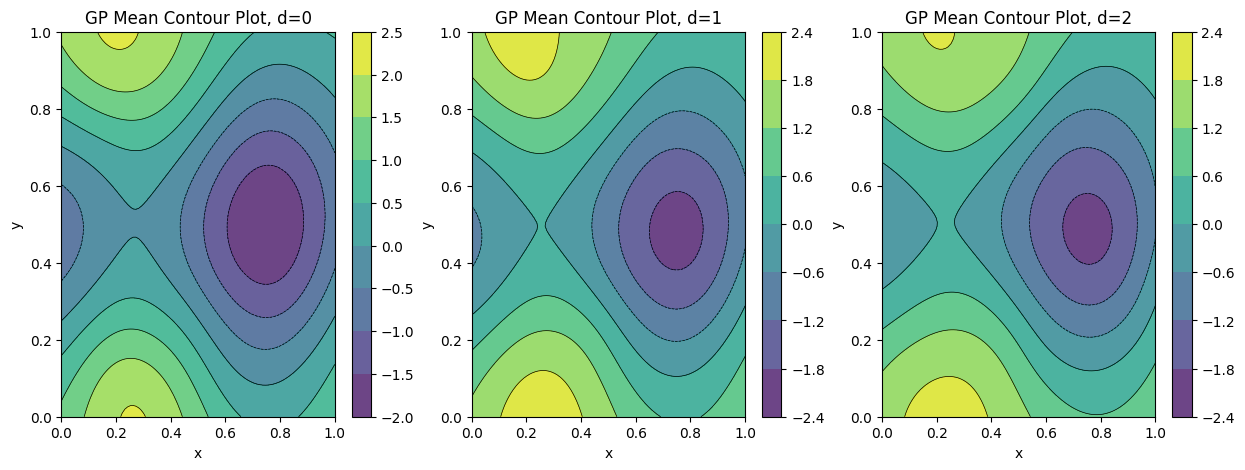

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood

# Assuming you have your GP model trained
# gp_model = your_pretrained_gp_model

# Function to plot contours
def plot_gp_contours(gp_model, x_range, y_range, d_values, title=''):
    x = np.linspace(x_range[0], x_range[1], 100)
    y = np.linspace(y_range[0], y_range[1], 100)
    X, Y = np.meshgrid(x, y)
    xy = np.vstack([X.ravel(), Y.ravel()]).T

    fig, axes = plt.subplots(1, len(d_values), figsize=(15, 5))

    for i, d in enumerate(d_values):
        d_tensor = torch.tensor([d] * xy.shape[0]).view(-1, 1)
        xy_tensor = torch.tensor(xy)
        input_tensor = torch.cat((xy_tensor, d_tensor), dim=1)
        
        with torch.no_grad():
            gp_mean, gp_var = gp_model.posterior(input_tensor).mean, gp_model.posterior(input_tensor).variance
        
        Z = gp_mean.view(X.shape).numpy()
        Z_var = gp_var.view(X.shape).numpy()

        ax = axes[i]
        contour = ax.contourf(X, Y, Z, cmap='viridis', alpha=0.8)
        ax.contour(X, Y, Z, colors='k', linewidths=0.5)
        ax.set_title(f'{title}, d={d}')
        fig.colorbar(contour, ax=ax)
        ax.set_xlabel('x')
        ax.set_ylabel('y')

    plt.show()

# Define ranges and discrete values
x_range = (0, 1)
y_range = (0, 1)
d_values = [0, 1, 2]  # Example discrete values

# Plot GP contours
plot_gp_contours(gp_model, x_range, y_range, d_values, title='GP Mean Contour Plot')


# Surface plot

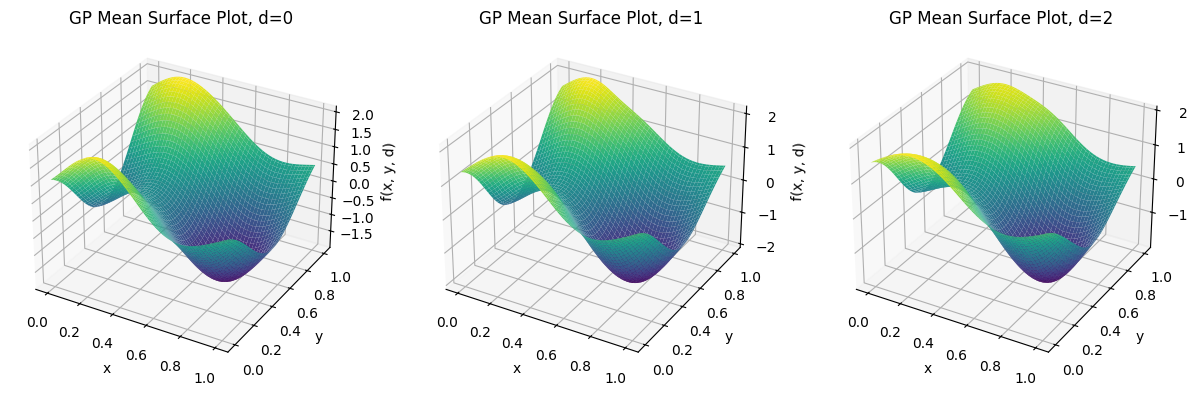

In [10]:
def plot_gp_surface(gp_model, x_range, y_range, d_values, title=''):
    x = np.linspace(x_range[0], x_range[1], 100)
    y = np.linspace(y_range[0], y_range[1], 100)
    X, Y = np.meshgrid(x, y)
    xy = np.vstack([X.ravel(), Y.ravel()]).T

    fig = plt.figure(figsize=(15, 5))

    for i, d in enumerate(d_values):
        d_tensor = torch.tensor([d] * xy.shape[0]).view(-1, 1)
        xy_tensor = torch.tensor(xy)
        input_tensor = torch.cat((xy_tensor, d_tensor), dim=1)
        
        with torch.no_grad():
            gp_mean = gp_model.posterior(input_tensor).mean
        
        Z = gp_mean.view(X.shape).numpy()

        ax = fig.add_subplot(1, len(d_values), i+1, projection='3d')
        ax.plot_surface(X, Y, Z, cmap='viridis')
        ax.set_title(f'{title}, d={d}')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('f(x, y, d)')

    plt.show()
    
# Plot GP surface plots
plot_gp_surface(gp_model, x_range, y_range, d_values, title='GP Mean Surface Plot')

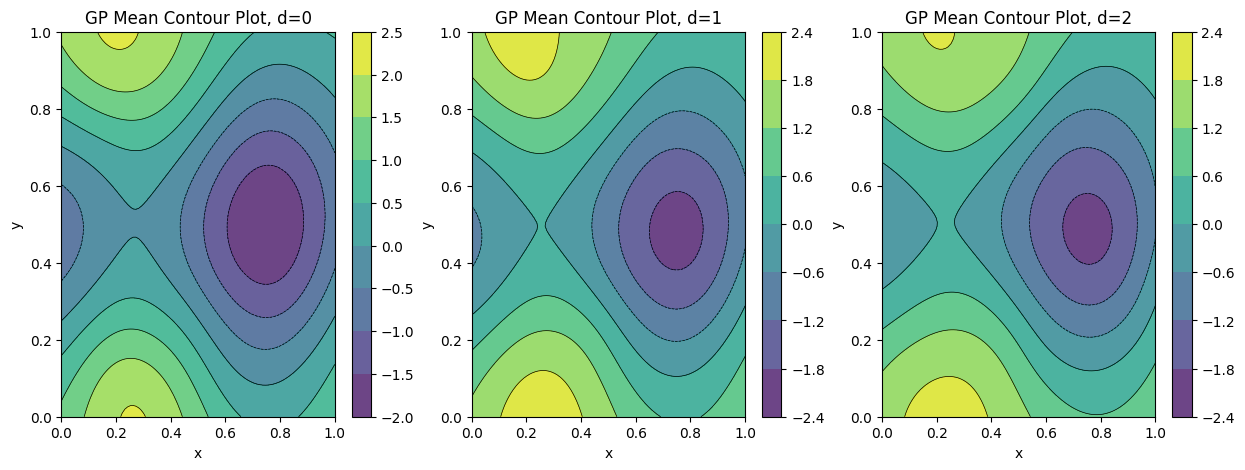

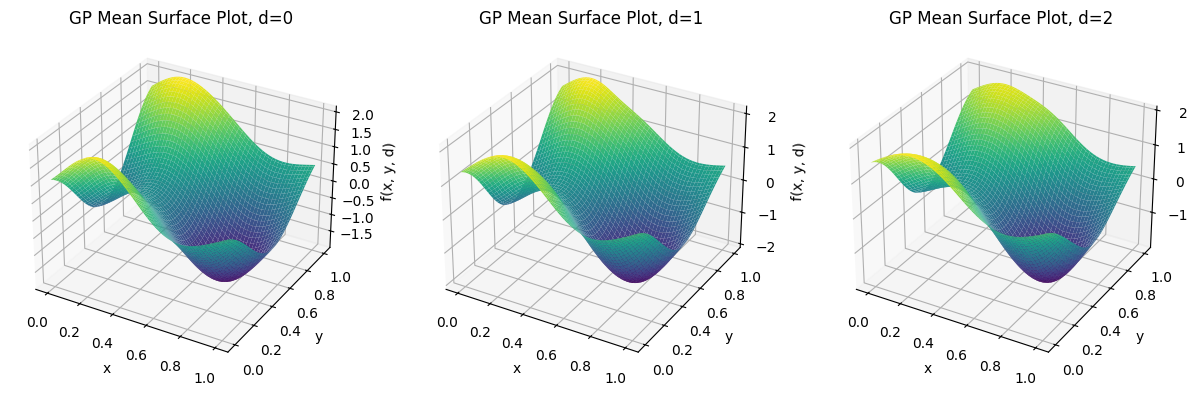

In [11]:
# Plot GP contours
plot_gp_contours(gp_model, x_range, y_range, d_values, title='GP Mean Contour Plot')
# Plot GP surface plots
plot_gp_surface(gp_model, x_range, y_range, d_values, title='GP Mean Surface Plot')

## Output with standard devation

In [13]:
def plot_gp_contours_with_uncertainty(gp_model, x_range, y_range, d_values, title=''):
    x = np.linspace(x_range[0], x_range[1], 100)
    y = np.linspace(y_range[0], y_range[1], 100)
    X, Y = np.meshgrid(x, y)
    xy = np.vstack([X.ravel(), Y.ravel()]).T

    fig, axes = plt.subplots(2, len(d_values), figsize=(15, 10))

    for i, d in enumerate(d_values):
        d_tensor = torch.tensor([d] * xy.shape[0]).view(-1, 1)
        xy_tensor = torch.tensor(xy)
        input_tensor = torch.cat((xy_tensor, d_tensor), dim=1)
        
        with torch.no_grad():
            gp_mean, gp_var = gp_model.posterior(input_tensor).mean, gp_model.posterior(input_tensor).variance
        
        Z_mean = gp_mean.view(X.shape).numpy()
        Z_std = gp_var.view(X.shape).sqrt().numpy()  # Standard deviation
        
        # Mean contour plot
        ax_mean = axes[0, i]
        contour_mean = ax_mean.contourf(X, Y, Z_mean, cmap='viridis', alpha=0.8)
        ax_mean.contour(X, Y, Z_mean, colors='k', linewidths=0.5)
        ax_mean.set_title(f'{title} Mean, d={d}')
        fig.colorbar(contour_mean, ax=ax_mean)
        ax_mean.set_xlabel('x')
        ax_mean.set_ylabel('y')

        # Standard deviation contour plot
        ax_std = axes[1, i]
        contour_std = ax_std.contourf(X, Y, Z_std, cmap='viridis', alpha=0.8)
        ax_std.contour(X, Y, Z_std, colors='k', linewidths=0.5)
        ax_std.set_title(f'{title} Std Dev, d={d}')
        fig.colorbar(contour_std, ax=ax_std)
        ax_std.set_xlabel('x')
        ax_std.set_ylabel('y')

    plt.show()

In [14]:
from mpl_toolkits.mplot3d import Axes3D

def plot_gp_surface_with_uncertainty(gp_model, x_range, y_range, d_values, title=''):
    x = np.linspace(x_range[0], x_range[1], 100)
    y = np.linspace(y_range[0], y_range[1], 100)
    X, Y = np.meshgrid(x, y)
    xy = np.vstack([X.ravel(), Y.ravel()]).T

    fig = plt.figure(figsize=(15, 10))

    for i, d in enumerate(d_values):
        d_tensor = torch.tensor([d] * xy.shape[0]).view(-1, 1)
        xy_tensor = torch.tensor(xy)
        input_tensor = torch.cat((xy_tensor, d_tensor), dim=1)
        
        with torch.no_grad():
            gp_mean, gp_var = gp_model.posterior(input_tensor).mean, gp_model.posterior(input_tensor).variance
        
        Z_mean = gp_mean.view(X.shape).numpy()
        Z_std = gp_var.view(X.shape).sqrt().numpy()  # Standard deviation

        # Mean surface plot
        ax_mean = fig.add_subplot(2, len(d_values), i+1, projection='3d')
        ax_mean.plot_surface(X, Y, Z_mean, cmap='viridis')
        ax_mean.set_title(f'{title} Mean, d={d}')
        ax_mean.set_xlabel('x')
        ax_mean.set_ylabel('y')
        ax_mean.set_zlabel('f(x, y, d)')

        # Standard deviation surface plot
        ax_std = fig.add_subplot(2, len(d_values), i+1 + len(d_values), projection='3d')
        ax_std.plot_surface(X, Y, Z_std, cmap='viridis')
        ax_std.set_title(f'{title} Std Dev, d={d}')
        ax_std.set_xlabel('x')
        ax_std.set_ylabel('y')
        ax_std.set_zlabel('Std Dev')

    plt.show()

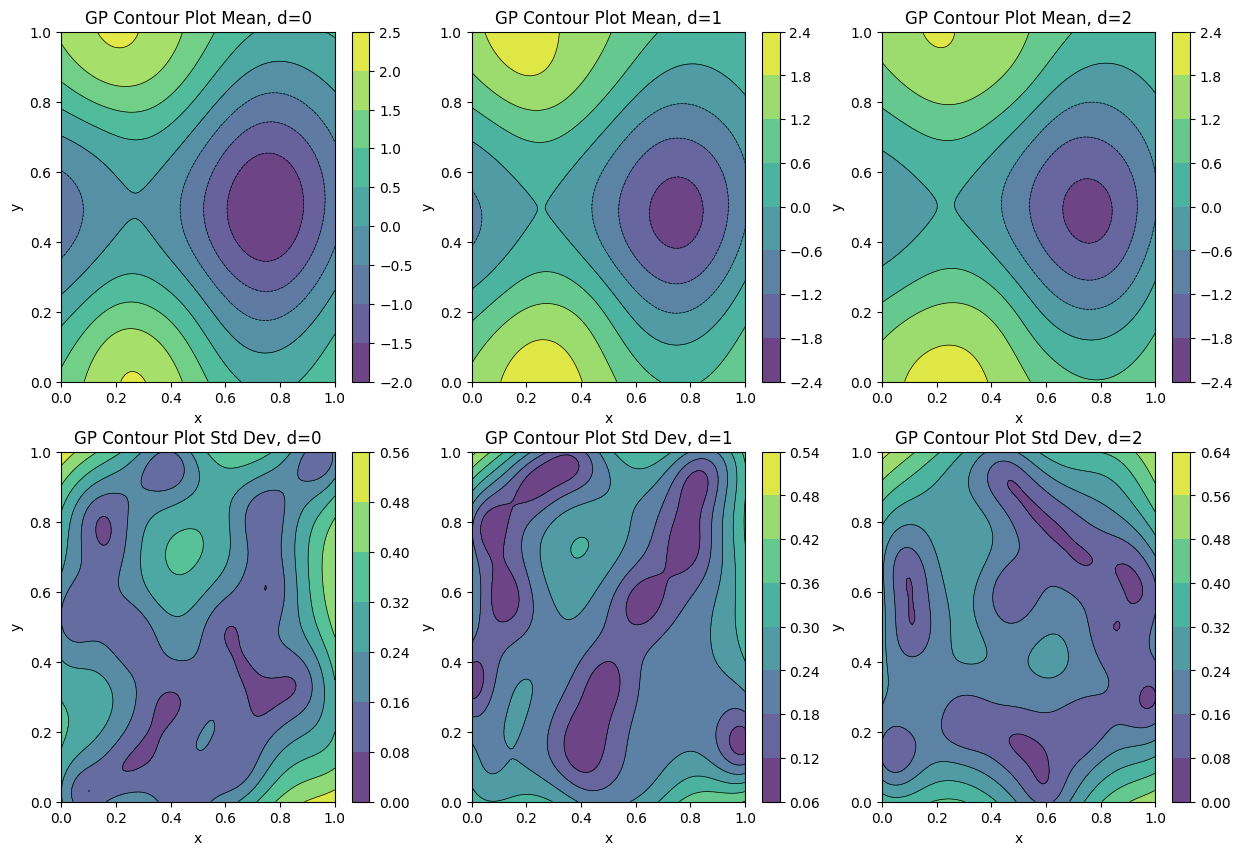

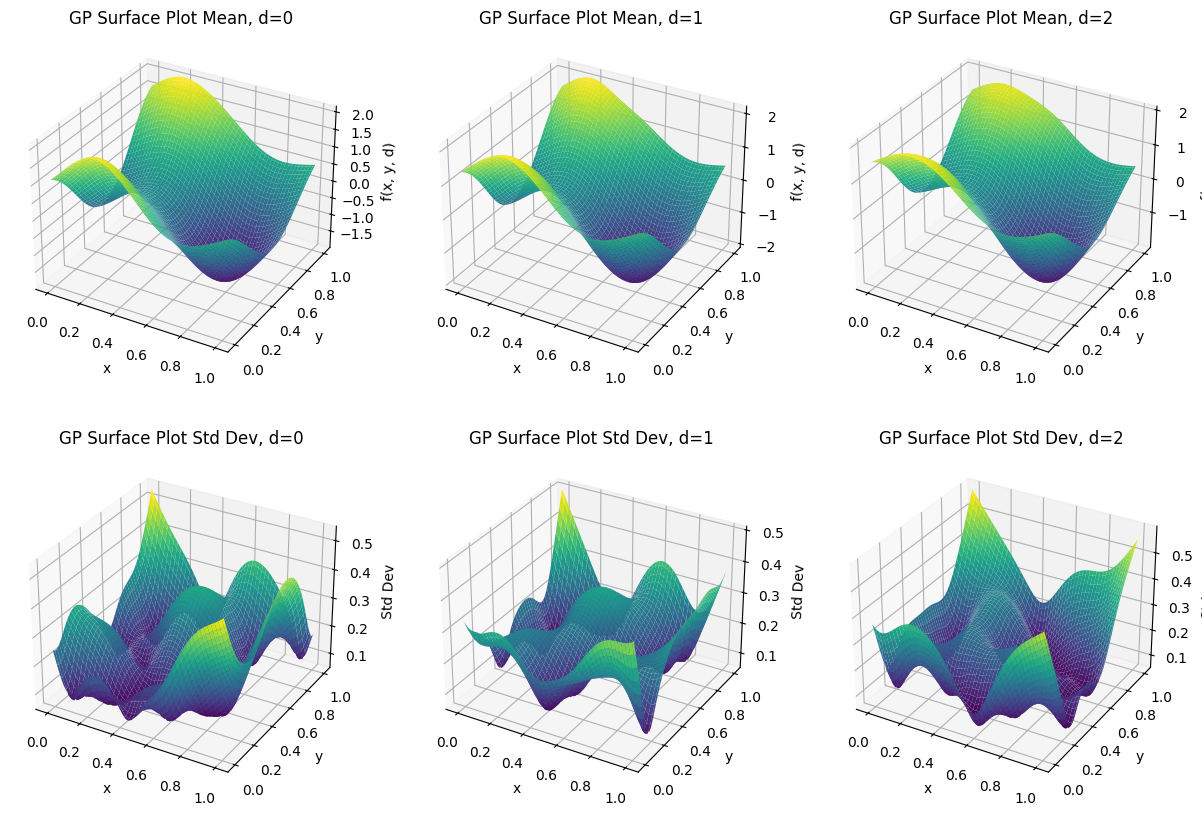

In [15]:
# Define ranges and discrete values
x_range = (0, 1)
y_range = (0, 1)
d_values = [0, 1, 2]  # Example discrete values

# Plot GP contours with uncertainty
plot_gp_contours_with_uncertainty(gp_model, x_range, y_range, d_values, title='GP Contour Plot')

# Plot GP surface plots with uncertainty
plot_gp_surface_with_uncertainty(gp_model, x_range, y_range, d_values, title='GP Surface Plot')


### Visualization on GP prior

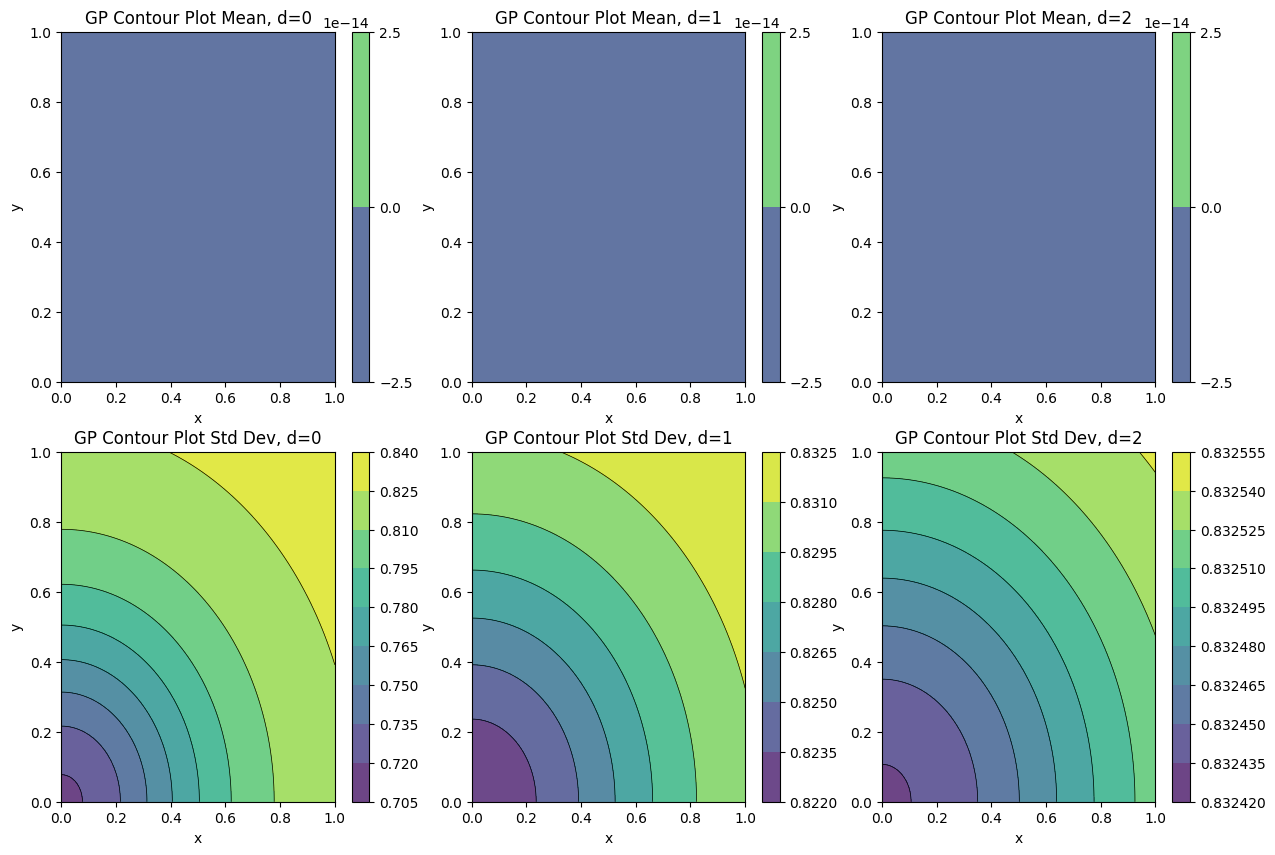

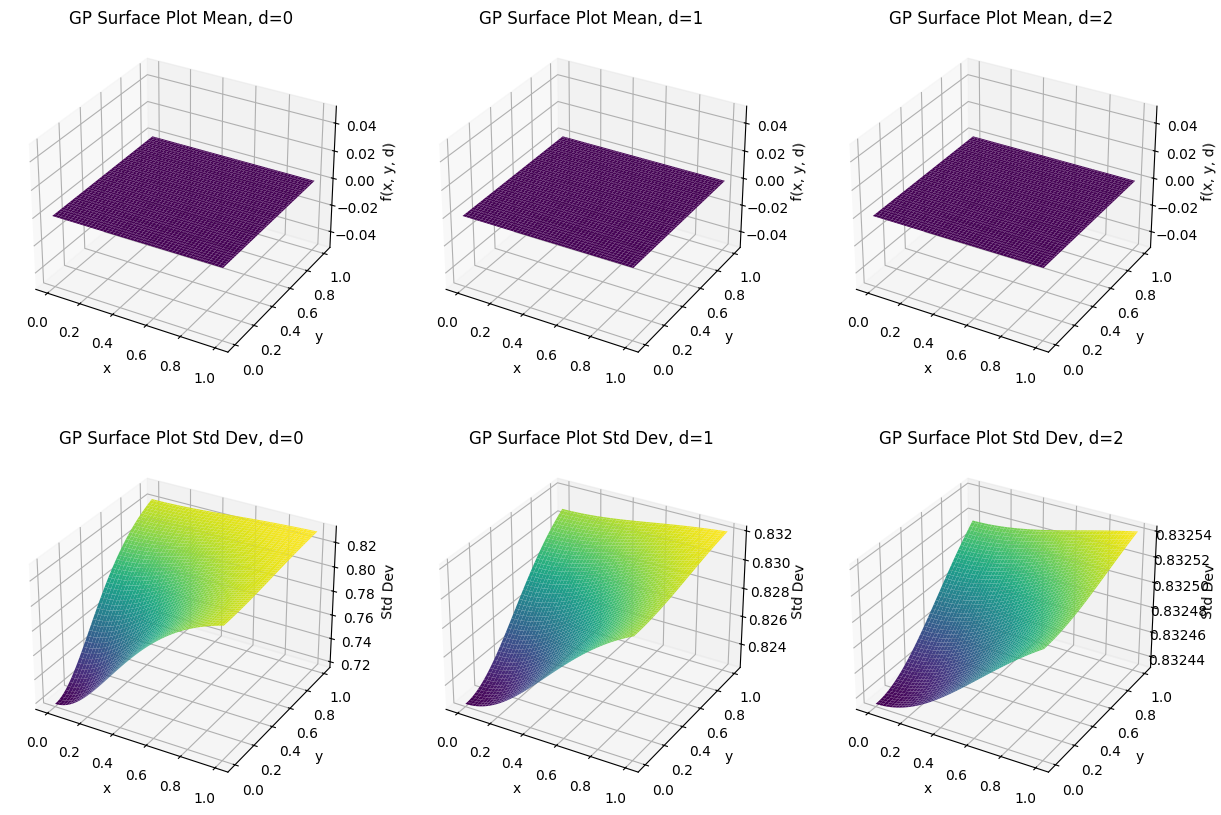

In [20]:
# Plot GP contours with uncertainty
plot_gp_contours_with_uncertainty(gp_none, x_range, y_range, d_values, title='GP Contour Plot')

# Plot GP surface plots with uncertainty
plot_gp_surface_with_uncertainty(gp_none, x_range, y_range, d_values, title='GP Surface Plot')